In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from utils import *
from hmmlearn import hmm

In [17]:
df = pd.read_csv('../HMM_randomportfolio.csv')
df.pricingdate = df.pricingdate.astype('datetime64')
df = df.tail(1000)
df = df.set_index(df.pricingdate).drop('pricingdate', axis=1)
df['predicted'] = np.zeros(len(df.priceclose))
df

,priceclose,r1,signal,predicted
pricingdate,,,,
2018-06-12,1293.170013,0.002628,1,0.0
2018-06-13,1296.170003,0.002320,1,0.0
2018-06-14,1303.909986,0.005971,1,0.0
2018-06-15,1308.450022,0.003482,1,0.0
2018-06-18,1299.859995,-0.006565,0,0.0
...,...,...,...,...
2022-05-24,1871.590002,0.002630,1,0.0
2022-05-25,1913.690022,0.022494,1,0.0
2022-05-26,1923.819968,0.005293,1,0.0


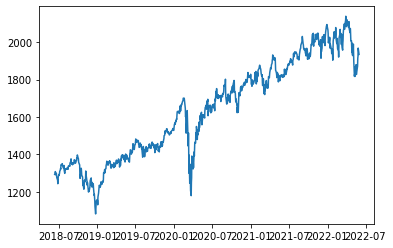

In [18]:
plt.plot(df.priceclose)

In [19]:
S = ['B','S'] # buy, hold, sell

In [20]:
n_visible = len(df.signal.unique())
n_hidden = len(S)

In [21]:
def forward(V, A, B, pi):
    T = V.shape[0]
    N = A.shape[0]
    
    alpha = np.zeros((T,N))
    alpha[0] = pi[0] * B[:,V[0]]  
    for t in range(0,T-1): alpha[t+1] = np.array([alpha[t,:].dot(A[:,j]) * (B[j,V[t+1]]) for j in range(N)])
            
    return alpha

In [22]:
def backward(V, A, B):
    T = V.shape[0]
    N = A.shape[0]
    
    beta = np.zeros((T,N))
    beta[T-1] = np.ones((N))
    for t in range(T-2, -1, -1): beta[t] = np.array([(beta[t+1,:] * B[:,V[t+1]]).dot(A[j,:]) for j in range(N)])
            
    return beta

In [ ]:
def vit():
    alpha = forward(V, A_bar, B_bar, pi_bar)
    beta = backward(V, A_bar, B_bar)
    xi = np.zeros((T, N, N))
    for t in range(T-1):
        denominator = sum(alpha[t,:].dot(A_bar[:,:]) * B_bar[:,V[t+1]] * beta[t+1,:])
        for i in range(N):
            for j in range(N):
                numerator = alpha[t,i] * A_bar[i,j] * (B_bar[j,V[t+1]]) * beta[t+1,j] 
                xi[t,i,j] = numerator / denominator 
    # note: gamma can be also computed as
    gamma = np.zeros((T,N))
    for t in range(T): gamma[t] = np.array([sum(xi[t,i,:]) for i in range(N)])

In [23]:
def baum_welch(V, A, B, pi, max_iter=100, epsilon=1e-5, print_states=True):
    T = V.shape[0]
    N = A.shape[0]
    
    # initialization: for the first iteration, our estimated parameters will be the initial ones
    A_bar = A
    B_bar = B
    pi_bar = pi
    
    for iteration in range(max_iter):
        alpha = forward(V, A_bar, B_bar, pi_bar)
        beta = backward(V, A_bar, B_bar)

        xi = np.zeros((T, N, N))
        for t in range(T-1):
            denominator = sum(alpha[t,:].dot(A_bar[:,:]) * B_bar[:,V[t+1]] * beta[t+1,:])
            for i in range(N):
                for j in range(N):
                    numerator = alpha[t,i] * A_bar[i,j] * (B_bar[j,V[t+1]]) * beta[t+1,j] 
                    xi[t,i,j] = numerator / denominator 

        # note: gamma can be also computed as
        gamma = np.zeros((T,N))
        for t in range(T): gamma[t] = np.array([sum(xi[t,i,:]) for i in range(N)])

        # expectation-maximization step
        pi_bar = np.array([gamma[0,i] for i in range(N)])

        prev = [A_bar, B_bar, pi_bar]
               
        A_bar = np.zeros((N,N))
        for i in range(N): A_bar[i] = np.array([xi[:-1,i,j].sum() / gamma[:-1,i].sum() for j in range(N)])

        B_bar = np.zeros(B.shape)
        for j in range(B.shape[0]):
            for k in range(B.shape[1]):
                # we need to define a list of times t_bar where V[t] is equal to k
                t_bar = [0,0]
                for i in sorted(V.unique()): t_bar[i] = [t for t in range(T) if V[t]==k]
                B_bar[j,k] = sum([gamma[t,j] for t in t_bar[k]]) / gamma[:,j].sum()
        
        A_delta = delta(A_bar, prev[0])
        B_delta = delta(B_bar, prev[1])
        pi_delta = delta(pi_bar, prev[2])
        
        e = A_delta + B_delta + pi_delta
        
        if print_states == True: print(f'iteration {iteration} - delta {e}')
        if e < epsilon: break

    return {'A_hat': A_bar, 'B_hat': B_bar, 'pi_hat': pi_bar, 'gamma': gamma}

def viterbi(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
    result = []
    for s in S:
        if s == 0:
            result.append("A")
        else:
            result.append("B")
 
    return result

In [34]:
est['gamma']

array([[0.30228615, 0.69771385],
       [0.24985878, 0.75014122],
       [0.25430124, 0.74569876],
       [0.31781393, 0.68218607],
       [0.47185564, 0.52814436],
       [0.53045972, 0.46954028],
       [0.51306753, 0.48693247],
       [0.62133219, 0.37866781],
       [0.66911708, 0.33088292],
       [0.67227442, 0.32772558],
       [0.63185163, 0.36814837],
       [0.53443881, 0.46556119],
       [0.34772014, 0.65227986],
       [0.26595122, 0.73404878],
       [0.2486307 , 0.7513693 ],
       [0.28717945, 0.71282055],
       [0.21015523, 0.78984477],
       [0.17927671, 0.82072329],
       [0.1792493 , 0.8207507 ],
       [0.21005943, 0.78994057],
       [0.28696782, 0.71303218],
       [0.24828251, 0.75171749],
       [0.26535525, 0.73464475],
       [0.34664242, 0.65335758],
       [0.31977679, 0.68022321],
       [0.37087909, 0.62912091],
       [0.52526104, 0.47473896],
       [0.59376238, 0.40623762],
       [0.59910781, 0.40089219],
       [0.54307064, 0.45692936],
       [0.

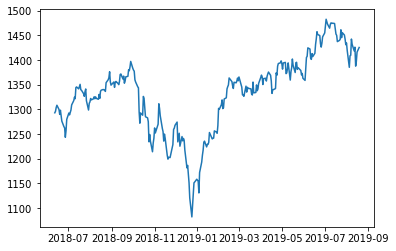

In [24]:
rolling1 = df[0:299]
state = np.empty(299)
plt.plot(rolling1.priceclose)

In [25]:
A_init = np.array([[.95,.05],
                  [.15,.85]])
B_init = np.array([[.8,.2],
                   [.2,.8]])
pi_init = np.array([1.1/2,.9/2])

In [26]:
rolling1

,priceclose,r1,signal,predicted
pricingdate,,,,
2018-06-12,1293.170013,0.002628,1,0.0
2018-06-13,1296.170003,0.002320,1,0.0
2018-06-14,1303.909986,0.005971,1,0.0
2018-06-15,1308.450022,0.003482,1,0.0
2018-06-18,1299.859995,-0.006565,0,0.0
...,...,...,...,...
2019-08-13,1426.120001,0.005457,1,0.0
2019-08-14,1387.679994,-0.026954,0,0.0
2019-08-15,1397.209976,0.006868,1,0.0


In [27]:
est= baum_welch(rolling1.signal, A_init, B_init, pi_init)
viter(est['A_hat'],est['B_hat'], est['pi_hat'])

iteration 0 - delta 0.043477302887192974
iteration 1 - delta 0.006140695856961344
iteration 2 - delta 0.0020701544518754536
iteration 3 - delta 0.0009052538401054384
iteration 4 - delta 0.00046342438834965087
iteration 5 - delta 0.00026386549112217825
iteration 6 - delta 0.00016228395194427356
iteration 7 - delta 0.00010587841016893504
iteration 8 - delta 7.242318341009892e-05
iteration 9 - delta 5.153066424333612e-05
iteration 10 - delta 3.793444207418911e-05
iteration 11 - delta 2.8784757472764292e-05
iteration 12 - delta 2.24550243514227e-05
iteration 13 - delta 1.7974559188396638e-05
iteration 14 - delta 1.474184627890756e-05
iteration 15 - delta 1.2371894550118832e-05
iteration 16 - delta 1.0611298653992806e-05
iteration 17 - delta 9.28912954362294e-06


In [28]:
est

{'A_hat': array([[0.77795335, 0.22204665],
        [0.14124517, 0.85875483]]),
 'B_hat': array([[0.59604786, 0.40395214],
        [0.37826601, 0.62173399]]),
 'pi_hat': array([0.30228615, 0.69771385]),
 'gamma': array([[0.30228615, 0.69771385],
        [0.24985878, 0.75014122],
        [0.25430124, 0.74569876],
        [0.31781393, 0.68218607],
        [0.47185564, 0.52814436],
        [0.53045972, 0.46954028],
        [0.51306753, 0.48693247],
        [0.62133219, 0.37866781],
        [0.66911708, 0.33088292],
        [0.67227442, 0.32772558],
        [0.63185163, 0.36814837],
        [0.53443881, 0.46556119],
        [0.34772014, 0.65227986],
        [0.26595122, 0.73404878],
        [0.2486307 , 0.7513693 ],
        [0.28717945, 0.71282055],
        [0.21015523, 0.78984477],
        [0.17927671, 0.82072329],
        [0.1792493 , 0.8207507 ],
        [0.21005943, 0.78994057],
        [0.28696782, 0.71303218],
        [0.24828251, 0.75171749],
        [0.26535525, 0.73464475],
       

In [29]:
for t in range(299): state[t] = np.argmax(est['gamma'][t])
rolling1['state'] = state[:299]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


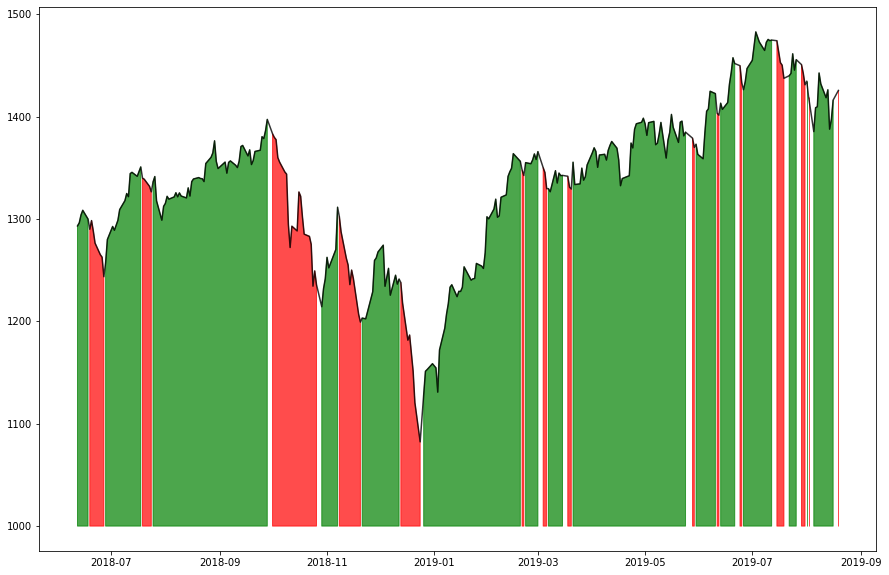

In [30]:
plt.figure(figsize=(15,10))
plt.plot(rolling1.priceclose, color='black',alpha=.8)
plt.fill_between(rolling1.index,rolling1.priceclose,1000,where=rolling1.state==0, color='red', alpha=.7)
plt.fill_between(rolling1.index,rolling1.priceclose,1000,where=rolling1.state==1, color='green', alpha=.7)

In [31]:
rolling1.r1[rolling1.state==1].mean()

0.002892890196688492

Text(0.5, 0, '% of increasing return')

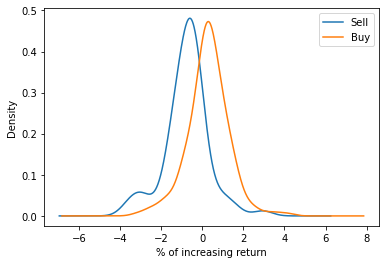

In [32]:
 # conditional distribution of r1 given the state
(rolling1.r1[rolling1.state==0]*100).plot.density()
(rolling1.r1[rolling1.state==1]*100).plot.density()
plt.legend(['Sell','Buy'])
plt.xlabel('% of increasing return')

In [33]:
prediction = rolling1[-2:-1].priceclose + (rolling1.r1[rolling1.state==rolling1[-2:-1].state[0]].mean())*rolling1[-2:-1].priceclose
df.predicted[298] = prediction[0]
prediction

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


pricingdate
2019-08-16    1420.14648
Name: priceclose, dtype: float64

In [ ]:
actual = rolling1[-1:].priceclose
actual

In [ ]:
loss = (prediction[0] - actual[0])**2
loss

In [ ]:
loss = []

for n in range(299,400):
    rolling = df[n-299:n]
    state = np.empty(299)
    est = baum_welch(rolling.signal, A_init, B_init, pi_init, print_states = False)
    
    for t in range(299): state[t] = np.argmax(est['gamma'][t])
    rolling['state'] = state[:299]
    
    prediction = rolling[-2:-1].priceclose + (rolling.r1[rolling.state==rolling[-2:-1].state[0]].mean())*rolling[-2:-1].priceclose
    df.predicted[n-1] = prediction[0]
    actual = rolling[-1:].priceclose
    loss.append((prediction[0] - actual[0])**2)
    print(f'iteration:{n}')
    
loss = np.array(loss)
total_loss = loss.sum()
mse = loss.mean()

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df.priceclose)
plt.plot(df.predicted)
plt.xlim((18100,18300))
plt.ylim((1300,1600))
plt.legend(('Actual', 'Predicted'))